#3# The deepscores dataset https://zenodo.org/records/4012193 contains thousands of pages of music in image (page scan) format, and a (huge) json file of bounding box annontations for these images.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import math

# Load JSON data into a dictionary
with open('./ds2_dense/deepscores_train.json') as file:
    data = json.load(file)

# You can now inspect the data structure
print(data.keys())  # Print keys to understand the structure

dict_keys(['info', 'annotation_sets', 'categories', 'images', 'annotations'])


### the first two keys are mostly useless- note that there are two annotation sets though, deepscores and muscima++. Deepscores is printed music and Muscima is handwritten music- We can use both in this combined set as the handwritten scores have more entropy which will hopefully improve any model 

In [2]:
# Example to access a nested part if 'data' contains a key that opens to a nested dictionary
nested_part = data['info']
print(nested_part)
# Example to access a nested part if 'data' contains a key that opens to a nested dictionary
nested_part = data['annotation_sets']
print(nested_part)

{'description': 'Deepscores training set in the OBB format', 'version': '2.0', 'year': 2020, 'contributor': 'Lukas Tuggener, Ismail Elezi, Yvan Satyawan, Jürgen Schmidhuber, Marcello Pelillo, Thilo Stadelmann', 'date_created': '2020-09-29', 'url': 'https://tuggeluk.github.io/deepscores/'}
['deepscores', 'muscima++']


### Categories contains the labels - note that the labels have different id/spelling between the datasets, however, equivalent labels have been assigned the same "color" (don't ask me why they did it this way- maybe just rename the color column "id")

In [3]:
# Example to access a nested part if 'data' contains a key that opens to a nested dictionary
nested_part = data['categories']
# print(nested_part)
# Assuming 'data' is your loaded JSON dictionary
categories_data = data['categories']
# Convert the 'categories' dictionary to a DataFrame
categories_df = pd.DataFrame(categories_data)
categories_df = categories_df.T
# Display the DataFrame to check it
categories_df.head(10)

,name,annotation_set,color
1,brace,deepscores,1
137,brace,muscima++,1
2,ledgerLine,deepscores,2
138,legerLine,muscima++,2
3,repeatDot,deepscores,7
139,repeatDot,muscima++,7
4,segno,deepscores,8
140,segno,muscima++,8
5,coda,deepscores,9
141,coda,muscima++,9


### the images table has the filenames as the primary key and then a list of all annotation_ids for that image. you will have to do a join from the following table to get the actual bounding box coordinates for an image

In [4]:
# # Example to access a nested part if 'data' contains a key that opens to a nested dictionary
# nested_part = data['images']
# print(nested_part)
# Assuming 'data' is your loaded JSON dictionary
images_data = data['images']

# Convert the 'categories' dictionary to a DataFrame
images_df = pd.DataFrame(images_data)

# Display the DataFrame to check it
images_df.head(5)

,id,filename,width,height,ann_ids
0,2,lg-94161796-aug-gonville--page-3.png,1960,2772,"[1113019, 1113020, 1113021, 1113022, 1113023, ..."
1,3,lg-139957803-aug-emmentaler--page-5.png,1960,2772,"[182814, 182815, 182816, 182817, 182818, 18281..."
2,4,lg-63506682-aug-emmentaler--page-6.png,1960,2772,"[435136, 435137, 435138, 435139, 435140, 43514..."
3,7,lg-102548668-aug-gonville--page-4.png,1960,2772,"[998808, 998809, 998810, 998811, 998812, 99881..."
4,8,lg-233786100286899765-aug-gutenberg1939--page-...,2970,4201,"[774295, 774296, 774297, 774298, 774299, 77430..."


### The annotations table contains the bounding boxes (a_bbox is parallel to the image dimensions, o_bbox is the bounding box with rotation), cat_id object label (notice that they gave you the id's for deepscores and muscima- probably should remap this to a new single id), area (in pixels), and image_id (foreign key). The coordinates are in pixels.

In [5]:
# # Example to access a nested part if 'data' contains a key that opens to a nested dictionary
# nested_part = data['annotations']
# print(nested_part)
# Assuming 'data' is your loaded JSON dictionary
anns_data = data['annotations']
# Convert the 'categories' dictionary to a DataFrame
anns_df = pd.DataFrame(anns_data)
anns_df = anns_df.T
# Display the DataFrame to check it
anns_df.head(5)

,a_bbox,o_bbox,cat_id,area,img_id,comments
1020,"[116.0, 139.0, 2315.0, 206.0]","[2315.0, 206.0, 2315.0, 139.0, 116.0, 139.0, 1...","[135, 208]",18945,679,instance:#000010;
1021,"[116.0, 309.0, 2315.0, 376.0]","[2315.0, 376.0, 2315.0, 309.0, 116.0, 309.0, 1...","[135, 208]",19223,679,instance:#000021;
1022,"[1880.0, 561.0, 1911.0, 564.0]","[1911.0, 564.0, 1911.0, 561.0, 1880.0, 561.0, ...","[2, 138]",120,679,instance:#000022;
1023,"[1883.0, 578.0, 1911.0, 580.0]","[1911.0, 580.0, 1911.0, 578.0, 1883.0, 578.0, ...","[2, 138]",27,679,instance:#000023;
1024,"[1827.0, 561.0, 1857.0, 564.0]","[1857.0, 564.0, 1857.0, 561.0, 1827.0, 561.0, ...","[2, 138]",112,679,instance:#000024;


### let's find a rotated bounding box to look at

In [28]:
# Assuming 'anns_df' is your DataFrame and 'o_bbox' contains the bounding boxes
# We need to find a bounding box with all unique coordinates.

# Function to check if all coordinates in the box are unique
def has_all_unique_coordinates(box):
    return len(set(box)) == len(box)

# Apply the function to each item in the 'o_bbox' column and filter
unique_boxes = anns_df[anns_df['o_bbox'].apply(has_all_unique_coordinates)]

# Check if we found any and print the first one if available
if not unique_boxes.empty:
    print("Found a rotated bounding box:", unique_boxes['o_bbox'].iloc[0])
else:
    print("No rotated bounding boxes found.")

Found a rotated bounding box: [1696.676513671875, 156.7941131591797, 1688.6470947265625, 143.41175842285156, 1670.7059326171875, 154.1764678955078, 1678.7353515625, 167.55882263183594]


In [26]:
anns_df.iloc[1092]

a_bbox                         [1432.0, 163.0, 1453.0, 179.0]
o_bbox      [1455.5, 168.50003051757812, 1445.0, 158.00003...
cat_id                                              [27, 157]
area                                                      279
img_id                                                   1072
comments         instance:#00003a;duration:4.;rel_position:1;
Name: 2112, dtype: object

### get the coordinates of the corners

In [38]:
obb = anns_df['o_bbox'].iloc[1092]
print(obb)

abb = anns_df['a_bbox'].iloc[1092]
abb

[1455.5, 168.50003051757812, 1445.0, 158.00003051757812, 1429.0, 174.00003051757812, 1439.5, 184.50003051757812]


[1432.0, 163.0, 1453.0, 179.0]

### plot the bounding box - the blue line is the diagonal of the parallel bounding box

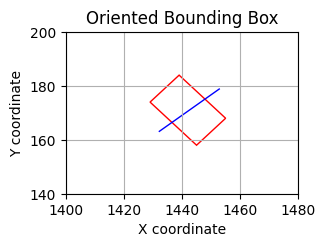

In [ ]:
# Define the coordinates for obb
points = [(1455, 168), (1445, 158), (1429, 174) , (1439, 184)] #obb
points1 = [(1432, 163), (1453, 179)] #abb

# Define the coordinates for abb
# points1 = [(abb[0], abb[1]), (abb[2], abb[3])] 

fig, ax = plt.subplots()
# Create a Polygon patch
polygon = patches.Polygon(points, closed=True, edgecolor='r', facecolor='none')
polygon1 = patches.Polygon(points1, closed=True, edgecolor='b', facecolor='none')
ax.add_patch(polygon)
ax.add_patch(polygon1)

# Set plot limits for better visibility
ax.set_xlim(1400, 1480)
ax.set_ylim(140, 200)

# Add grid and labels for better visualization
ax.grid(True)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Oriented Bounding Box')

fig.set_size_inches(3, 2.1)
plt.show()

### let's figure out what object this is

In [41]:
anns_df.iloc[1094]

a_bbox                         [1115.0, 366.0, 1137.0, 384.0]
o_bbox      [1139.4000244140625, 375.8000183105469, 1132.8...
cat_id                                              [29, 158]
area                                                      233
img_id                                                   1072
comments         instance:#00003c;duration:2;rel_position:-4;
Name: 2114, dtype: object

In [11]:
categories_df[47:48]

,name,annotation_set,color
27,noteheadBlackInSpace,deepscores,37


### it's a note- let's figure out what image it's in so we can visualize it

In [12]:
images_df[images_df['id']==1072]

,id,filename,width,height,ann_ids
862,1072,lg-174521423366315269-aug-lilyjazz--page-3.png,1921,2717,"[2082, 2083, 2084, 2085, 2086, 2087, 2088, 208..."


In [42]:
image_path = images_df.loc[1094]['filename']
image_path

'lg-212107868-aug-lilyjazz--page-2.png'

### now let's draw the box on the image

In [14]:
def draw_obb_on_image(image_path, obb, zoom=False):
    # Load the image
    img = Image.open(image_path)
    
    # Create a matplotlib figure and axis
    fig, ax = plt.subplots()
    ax.imshow(img)
    # Set plot limits for better visibility
    if zoom:    
        ax.set_xlim(1000, 1750)
        ax.set_ylim(400, 0)
    # Create a polygon patch from the OBB coordinates
    polygon = patches.Polygon([(obb[i], obb[i+1]) for i in range(0, len(obb), 2)], 
                              closed=True, edgecolor='red', fill=False)
    ax.add_patch(polygon)
    
    # Show the plot
    plt.show()

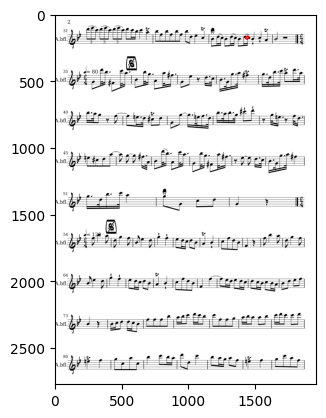

In [43]:
draw_obb_on_image('./ds2_dense/images/'+image_path, obb)

### zoomed in- looks pretty good!

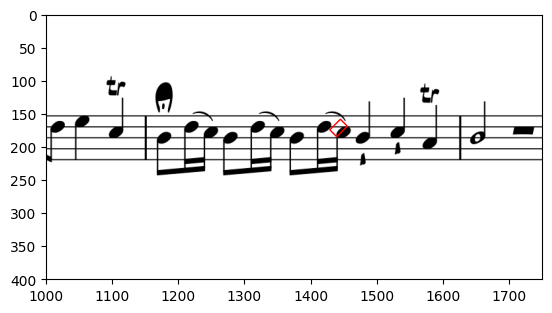

In [44]:
draw_obb_on_image('./ds2_dense/images/'+image_path, obb, True)

### possible code to convert 4-corner coordinates to (center_x,center_y,W,H,R) normalized

In [18]:
import numpy as np
from shapely.geometry import Polygon

def obb_to_yolo(obb, img_width, img_height):
    # Assuming 'obb' is a list of eight coordinates: [x1, y1, x2, y2, x3, y3, x4, y4]
    polygon = Polygon([(obb[i], obb[i + 1]) for i in range(0, len(obb), 2)])
    min_rect = polygon.minimum_rotated_rectangle
    
    # Extract the corners of the minimum rotated rectangle
    corners = np.array(min_rect.exterior.coords)
    
    # Calculate width, height and center of the rectangle
    edge1 = np.linalg.norm(corners[0] - corners[1])
    edge2 = np.linalg.norm(corners[1] - corners[2])
    width = max(edge1, edge2)
    height = min(edge1, edge2)
    
    center = min_rect.centroid.coords[0]
    center_x = center[0]
    center_y = center[1]
    
    # Calculate rotation angle
    angle = np.rad2deg(np.arctan2(corners[1][1] - corners[0][1], corners[1][0] - corners[0][0]))
    
    # Normalize width, height, and center coordinates
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height
    
    return [center_x, center_y, width, height, angle]

# Example usage:
obb = anns_df['o_bbox'].iloc[1092]
img_width = images_df.loc[862]['width']
img_height = images_df.loc[862]['height']

yolo_bbox = obb_to_yolo(obb, img_width, img_height)
yolo_bbox

[np.float64(0.7507808433107753),
 np.float64(0.06302908741905705),
 np.float64(0.011778978135330308),
 np.float64(0.0054653082093917916),
 np.float64(135.0)]

In [19]:
def centroid_from_corners(coords):
    # coords should be a list of eight elements: [x1, y1, x2, y2, x3, y3, x4, y4]
    xs = coords[0::2]  # Extracts every second element starting from 0
    ys = coords[1::2]  # Extracts every second element starting from 1
    centroid_x = sum(xs) / len(xs)
    centroid_y = sum(ys) / len(ys)
    return (centroid_x, centroid_y)

In [20]:
centroid_from_corners(obb)

(1442.25, 171.25003051757812)

In [21]:
(yolo_bbox[0]*1921, yolo_bbox[1]*2717)

(np.float64(1442.2499999999993), np.float64(171.250030517578))

### matplotlib hates yolo coordinates, so we will need to convert them back any time we want to plot

In [22]:
def yolo_to_corners(center_x, center_y, width, height, rotation, img_width, img_height):
    center_x *= img_width
    center_y *= img_height
    width *= img_width
    height *= img_height
    rotation = np.deg2rad(rotation)
    
    corners = np.array([
        [-width / 2, -height / 2],
        [width / 2, -height / 2],
        [width / 2, height / 2],
        [-width / 2, height / 2]
    ])
    
    R = np.array([
        [np.cos(rotation), -np.sin(rotation)],
        [np.sin(rotation), np.cos(rotation)]
    ])
    
    rot_corners = np.dot(corners, R)
    rot_corners[:, 0] += center_x
    rot_corners[:, 1] += center_y
    
    return rot_corners.flatten()

### plot the yolo box

In [23]:
def draw_rotated_yolo_bbox(image_path, bbox, img_width, img_height, zoom=False):
    img = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img)

    corners = yolo_to_corners(bbox[0], bbox[1], bbox[2], bbox[3], bbox[4], img_width, img_height)
    polygon = patches.Polygon(np.array(corners).reshape(4, 2), closed=True, edgecolor='r', facecolor='none')
    ax.add_patch(polygon)

    if zoom:
        buffer = 100
        ax.set_xlim(min(corners[0::2]) - buffer, max(corners[0::2]) + buffer)
        ax.set_ylim(max(corners[1::2]) + buffer, min(corners[1::2]) - buffer)
    else:
        ax.set_xlim(0, img_width)
        ax.set_ylim(img_height, 0)
    
    plt.show()

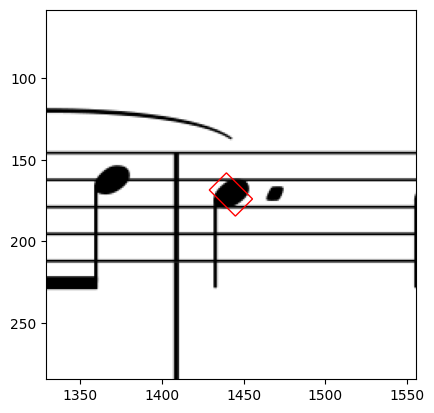

In [24]:
draw_rotated_yolo_bbox('./ds2_dense/images/'+image_path, yolo_bbox, img_width, img_height, True)